In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime, timedelta
import pickle
import plotly.offline as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
import seaborn as sns

In [17]:
turbine_readings = pickle.load(open("./data/turbine_readings_5mins.pickle","rb")) 
weather_data = pd.read_csv("hourly_weather_data.csv")
print(weather_data.shape)

(9019, 45)


Preprocessing both turbine data and weather data.

In [18]:
weather_data = weather_data.dropna(axis=1, how="all")
weather_data["timestamp"] = pd.to_datetime(weather_data["valid_time_gmt"], unit="s") - pd.Timedelta("08:00:00")
weather_data["weather_date"] = weather_data["timestamp"].dt.date
weather_data["weather_time"] = weather_data["timestamp"].dt.time
weather_data["weather_month"] = weather_data["timestamp"].dt.month
weather_data["weather_day_of_month"] = weather_data["timestamp"].dt.day
weather_data["weather_day_of_week"] = weather_data["timestamp"].dt.dayofweek

turbine_readings["turbine_date"] = turbine_readings["timestamp"].dt.date
turbine_readings["turbine_time"] = turbine_readings["timestamp"].dt.time
turbine_readings["turbine_month"] = turbine_readings["timestamp"].dt.month
turbine_readings["turbine_day_of_month"] = turbine_readings["timestamp"].dt.day
turbine_readings["turbine_day_of_week"] = turbine_readings["timestamp"].dt.dayofweek

turbine_names = list(turbine_readings.columns.values)
turbine_names.remove("timestamp")
turbine_names.remove("kW_Turbine86")
turbine_readings["avg_kW_reading"] = turbine_readings[turbine_names].sum(axis=1)/len(turbine_names)

feature_dict = {"wspd" : "Average Windspeed (mph)",
                "wdir" : "Wind Direction",
                "temp" : "Temperature (Farenheit)",
                "feels_like" : "Feels Like Temperature (Farenheit)"}

Subset weather data to only include time range of turbine readings.

In [19]:
max_date_readings = max(turbine_readings["timestamp"])
weather_data = weather_data.loc[weather_data["timestamp"] <= max_date_readings]
print(weather_data.shape)

(650, 32)


In [20]:
for feature in feature_dict:
    trace1 = go.Scatter(
        x=turbine_readings["timestamp"],
        y=turbine_readings["avg_kW_reading"],
        mode="lines",
        name="Average Turbine Reading"
    )

    trace2 = go.Scatter(
        x=weather_data["timestamp"],
        y=weather_data[feature],
        mode="lines",
        name=feature_dict[feature],
        yaxis="y2"
    )

    data = [trace1, trace2]
    layout = go.Layout(
        title='Turbine Output vs. ' + feature_dict[feature],
        yaxis=dict(
            title='Turbine Output (kWh)',
            titlefont=dict(
                color='#1f77b4'
            ),
            tickfont=dict(
                color='#1f77b4'
            )
        ),
        yaxis2=dict(
            title=feature_dict[feature],
            titlefont=dict(
                color='#ff7f0e'
            ),
            tickfont=dict(
                color='#ff7f0e'
            ),
            overlaying='y',
            side='right'
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [21]:
turbine_weather_df = pd.merge_asof(left=turbine_readings, right=weather_data, on="timestamp", direction="nearest")
turbine_weather_df.to_csv("./data/turbine&weather_combined_5mins.csv", index=False)
pickle_out = open("./data/turbine&weather_combined_5mins.pickle", "wb")
pickle.dump(turbine_weather_df, pickle_out)
pickle_out.close()

In [31]:
for feature in feature_dict:
    trace = go.Scatter(x=turbine_weather_df[feature],
                       y=turbine_weather_df["avg_kW_reading"],
                       mode='markers',
                       opacity=.8)
    data=[trace]

    layout = go.Layout(
        title='Turbine Output vs. ' + feature_dict[feature],
        yaxis=dict(
            title='Turbine Output (kWh)'
        ),
        xaxis=dict(
            title=feature_dict[feature]
        )
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

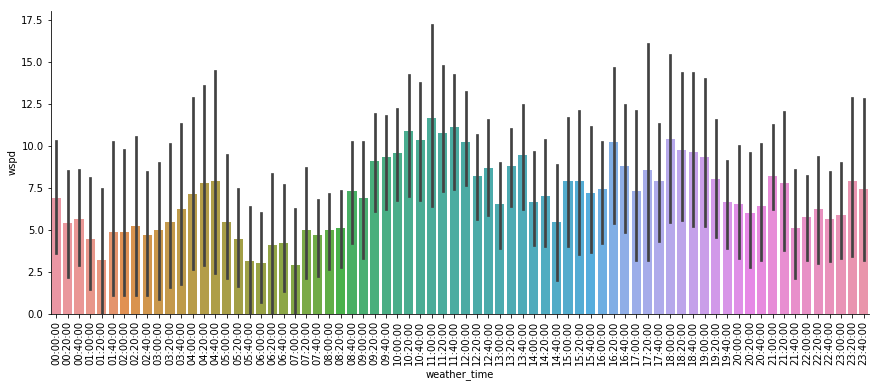

In [23]:
fig = sns.catplot(x="weather_time" ,y="wspd", data=weather_data, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)

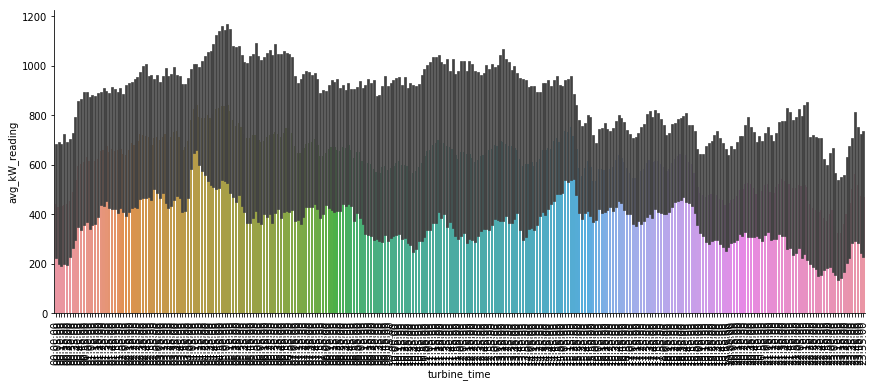

In [24]:
fig = sns.catplot(x="turbine_time" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)

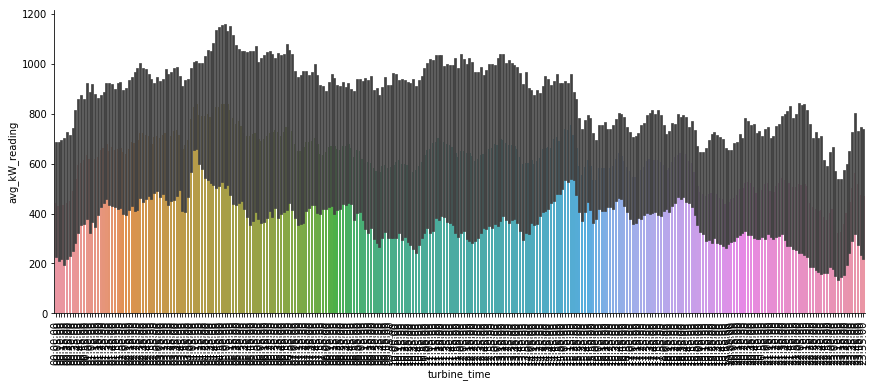

In [25]:
turbine_readings = turbine_readings.sort_values(by=["turbine_time"])
fig = sns.catplot(x="turbine_time" ,y="avg_kW_reading", data=turbine_readings, kind='bar', aspect=2.5, ci=95, n_boot=1000)
fig.set_xticklabels(rotation=90)

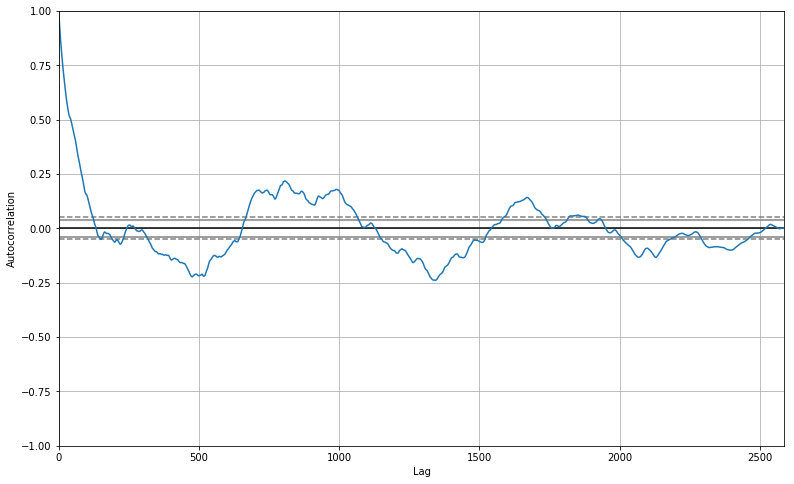

In [50]:
turbine_readings = turbine_readings.sort_index()
turbine_readings_subset = turbine_readings.loc[turbine_readings["timestamp"] <= datetime(2016, 6, 30)]

from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(13,8))
autocorrelation_plot(turbine_readings_subset["avg_kW_reading"])

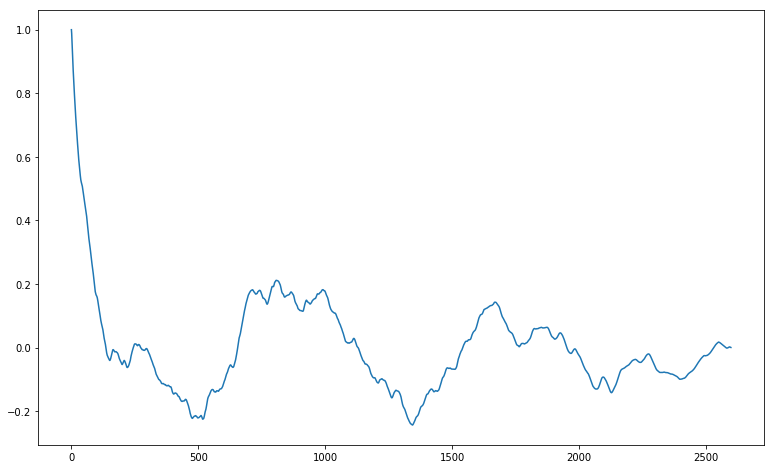

In [18]:
from statsmodels.tsa.stattools import acf
autocorrelation = acf(turbine_readings["avg_kW_reading"], nlags=3000)
plt.figure(figsize=(13,8))
plt.plot(autocorrelation)

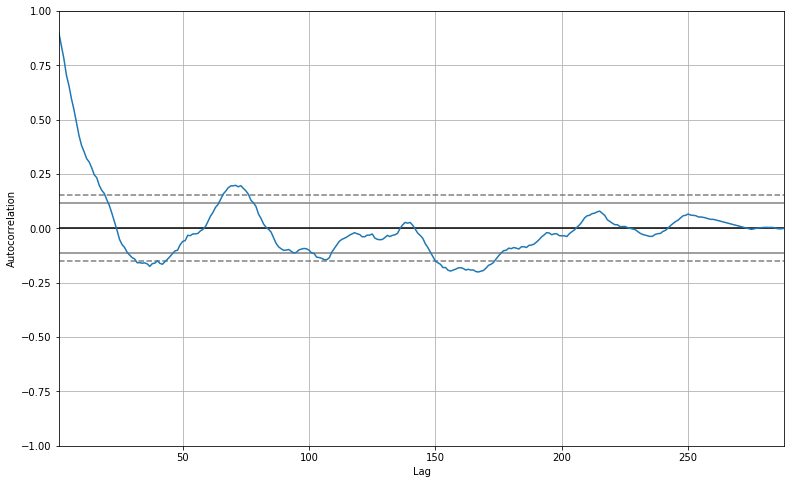

In [21]:
weather_data_subset = weather_data.loc[weather_data["timestamp"] <= datetime(2016, 1, 5)]
weather_data_subset = weather_data_subset.dropna(subset=["wspd"])
plt.figure(figsize=(13,8))
autocorrelation_plot(weather_data_subset["wspd"])

           0
60  0.031417
61  0.056164
62  0.073711
63  0.096908
64  0.110148
65  0.132765
66  0.157075
67  0.170705
68  0.186512
69  0.195018
70  0.195798
71  0.197806
72  0.191150
73  0.196325
74  0.183904
75  0.172764
76  0.157202
77  0.129472
78  0.117355
79  0.100856
            0
130 -0.042430
131 -0.032272
132 -0.037728
133 -0.032066
134 -0.029607
135 -0.023036
136 -0.000488
137  0.015656
138  0.027444
139  0.023861
140  0.027196
141  0.014519
142 -0.003154
143 -0.021980
144 -0.032607
145 -0.045669
146 -0.070771
147 -0.088188
148 -0.108807
149 -0.129297
(288,)


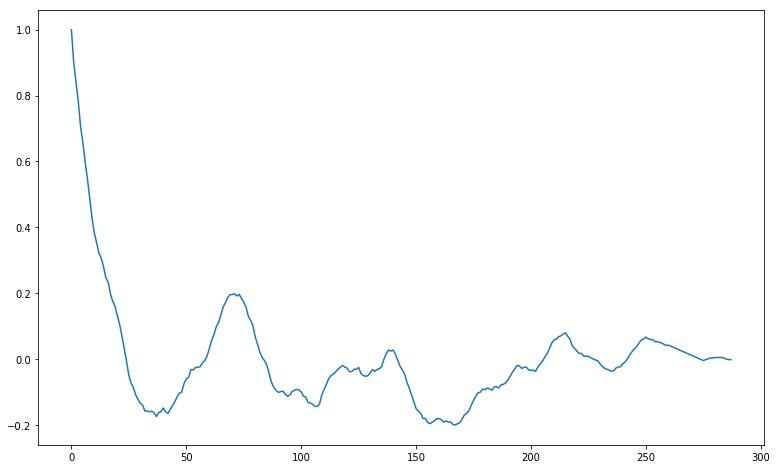

In [24]:
autocorrelation = acf(weather_data_subset["wspd"], nlags=5000)
df = pd.DataFrame(autocorrelation)
print(df.iloc[60:80,:])
print(df.iloc[130:150,:])
print(weather_data_subset["wspd"].shape)
plt.figure(figsize=(13,8))
plt.plot(autocorrelation)